Lung histopathology

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# importing libraries

import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score, cohen_kappa_score, precision_score, recall_score, accuracy_score, confusion_matrix
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input
from keras.models import Sequential
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
#from keras.layers.normalization import BatchNormalization
from keras.models import Model, Sequential
from keras.applications.xception import Xception
from keras.applications import *
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from PIL import Image
import random
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier 
from keras.callbacks import EarlyStopping
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.decomposition import PCA

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
image_set= '/content/drive/MyDrive/lung_image_sets'

In [5]:
for i,d in enumerate([image_set]):
    filepaths=[]
    labels=[]
    classlist=os.listdir(d)
    for klass in classlist:
        classpath=os.path.join(d,klass)
        if os.path.isdir(classpath):
            flist=os.listdir(classpath)
            for f in flist:
                fpath=os.path.join(classpath,f)
                filepaths.append(fpath)
                labels.append(klass)                   
    Fseries= pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    lung_df=pd.concat([Fseries, Lseries], axis=1)
df=pd.concat([lung_df], axis =0).reset_index(drop=True)# make a combined dataframe

print(df['labels'].value_counts())

lung_n      5000
lung_scc    5000
lung_aca    5000
Name: labels, dtype: int64


In [6]:
from sklearn.model_selection import train_test_split

In [7]:
train_split=.6
test_split=.2
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df), ' _test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  9000  _test_df length:  3000   valid_df length:  3000


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
height=224
width=224
channels=3
batch_size=32
img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ('test batch size: ' ,test_batch_size, '  test steps: ', test_steps)
def scalar(img):
    return img/127.5-1  # scale pixel between -1 and +1
gen=ImageDataGenerator(preprocessing_function=scalar)
train_set=gen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
test_set=gen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)
validate_set=gen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
#classes=list(train_gen.class_indices.keys())
#class_count=len(classes)

test batch size:  75   test steps:  40
Found 9000 validated image filenames belonging to 3 classes.
Found 3000 validated image filenames belonging to 3 classes.
Found 3000 validated image filenames belonging to 3 classes.


In [9]:
# This code block should create an instance of an ImageDataGenerator called datagen 
def DataGenerator(train_set, validate_set, IMG_SIZE):
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                 rescale=1./255,#rescale factor
                                 rotation_range=10,# Degree range for random rotations.
                                 horizontal_flip=True,#horizontal flip in images
                                 vertical_flip=True)#vertical flip in images

    datagen.mean=np.array([103.939, 116.779, 123.68],dtype=np.float32).reshape(1,1,3)

    train_gen = datagen.flow_from_directory(train_set,
                                            target_size=(IMG_SIZE, IMG_SIZE),
                                            color_mode='rgb', 
                                            class_mode='categorical',
                                            batch_size=train_set)

    val_gen = datagen.flow_from_directory(validate_set, 
                                          target_size=(IMG_SIZE, IMG_SIZE),
                                          color_mode='rgb', 
                                          class_mode='categorical',
                                          batch_size=validate_set)

    datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                 rescale=1./255)
    
    datagen.mean=np.array([103.939, 116.779, 123.68],dtype=np.float32).reshape(1,1,3)

    test_gen = datagen.flow_from_directory(test_set, 
                                           target_size=(IMG_SIZE, IMG_SIZE),
                                           color_mode='rgb', 
                                           class_mode='categorical',
                                           shuffle=False)
    
    return train_gen, val_gen, test_gen

In [10]:
IMAGE_SIZE = [224, 224]

In [11]:
# importing libraries

import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from  tensorflow import keras

In [12]:
# import os                       # for working with files
# import numpy as np              # for numerical computationss
# import pandas as pd             # for working with dataframes
# import seaborn as sns
# import torch                    # Pytorch module 
# import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
# import torch.nn as nn           # for creating  neural networks
# from torch.utils.data import DataLoader # for dataloaders 
# from PIL import Image           # for checking images
# import torch.nn.functional as F # for functions for calculating loss
# import torchvision.transforms as transforms   # for transforming images into tensors 
# from torchvision.utils import make_grid       # for data checking
# from torchvision.datasets import ImageFolder  # for working with classes and images
# from torchsummary import summary              # for getting the summary of our model
# import tensorflow as ts 
# from  tensorflow import keras
# import itertools
# from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

# %matplotlib inline

In [13]:
model_1 = keras.models.Sequential()

model_1.add(keras.layers.Conv2D(32, 3, activation='relu', input_shape=(224, 224, 3)))

model_1.add(keras.layers.Dropout(0.1))
model_1.add(keras.layers.MaxPooling2D())

model_1.add(keras.layers.Conv2D(64, 3, activation='relu'))
model_1.add(keras.layers.Dropout(0.15))
model_1.add(keras.layers.MaxPooling2D())

model_1.add(keras.layers.Conv2D(128, 3, activation='relu'))
model_1.add(keras.layers.Dropout(0.2))
model_1.add(keras.layers.MaxPooling2D())

model_1.add(keras.layers.Flatten())
model_1.add(keras.layers.Dense(256, activation='relu'))
model_1.add(keras.layers.Dense(3, activation='softmax'))

model_1.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 dropout (Dropout)           (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 dropout_1 (Dropout)         (None, 109, 109, 64)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                    

In [14]:
# COMPILING THE MODEL

model_1.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
#executing the model
history = model_1.fit(train_set, validation_data = (validate_set), epochs = 50, verbose = 1)


Epoch 1/50
282/282 [==============================] - 1953s 7s/step - loss: 0.4559 - accuracy: 0.8607 - val_loss: 0.2631 - val_accuracy: 0.8900
Epoch 2/50
282/282 [==============================] - 136s 484ms/step - loss: 0.1923 - accuracy: 0.9217 - val_loss: 0.2050 - val_accuracy: 0.9190
Epoch 3/50
282/282 [==============================] - 138s 489ms/step - loss: 0.1269 - accuracy: 0.9496 - val_loss: 0.2005 - val_accuracy: 0.9267
Epoch 4/50
282/282 [==============================] - 139s 492ms/step - loss: 0.1289 - accuracy: 0.9549 - val_loss: 0.1724 - val_accuracy: 0.9443
Epoch 5/50
282/282 [==============================] - 138s 490ms/step - loss: 0.0858 - accuracy: 0.9674 - val_loss: 0.1736 - val_accuracy: 0.9427
Epoch 6/50
282/282 [==============================] - 138s 491ms/step - loss: 0.0543 - accuracy: 0.9812 - val_loss: 0.1703 - val_accuracy: 0.9443
Epoch 7/50
282/282 [==============================] - 148s 524ms/step - loss: 0.0327 - accuracy: 0.9886 - val_loss: 0.2340 - v

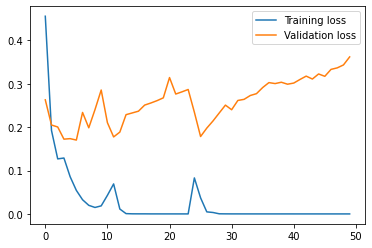

In [ ]:
# plotting the loss
plt.plot(history.history['loss'],label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
#plt.title('loss')
plt.legend()
plt.show()

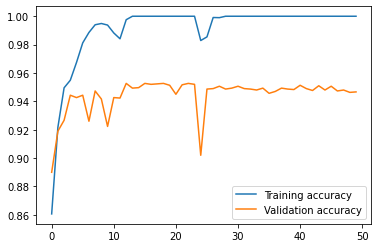

In [ ]:
# Both Validation and Training accuracy is shown here

plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
#plt.title('Accuracy')
plt.legend()
plt.show()

In [ ]:
# CHECKING THE CONFUSION MATRIX

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
Y_pred = model_1.predict(test_set)
y_pred = np.argmax(Y_pred ,axis =1)


40/40 [==============================] - 470s 12s/step


In [ ]:
preds = model_1.predict(test_set,verbose=1)
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

40/40 [==============================] - 32s 810ms/step


<Axes: >

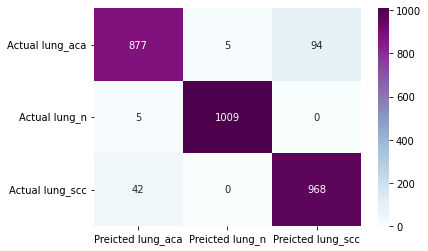

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix( y_true= test_set.classes, y_pred= y_pred, labels=[0, 1,2]), index=['Actual lung_aca','Actual lung_n','Actual lung_scc'],columns=['Preicted lung_aca','Preicted lung_n','Preicted lung_scc'])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d",cmap="BuPu")

In [ ]:
print('Classification Report')
target_names = ['lung_aca','lung_n','lung_scc']
print(classification_report(test_set.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

    lung_aca       0.95      0.90      0.92       976
      lung_n       1.00      1.00      1.00      1014
    lung_scc       0.91      0.96      0.93      1010

    accuracy                           0.95      3000
   macro avg       0.95      0.95      0.95      3000
weighted avg       0.95      0.95      0.95      3000



In [ ]:
loss, acc = model_1.evaluate_generator(test_set, len(test_set))

print ("\n\n================================\n\n")
print ("Loss: {}".format(loss))
print ("Accuracy: {0:.2f} %".format(acc * 100))
print ("\n\n================================\n\n")

test_set.reset()

<ipython-input-22-0bfbb599d6c5>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, acc = model_1.evaluate_generator(test_set, len(test_set))






Loss: 0.2937440872192383
Accuracy: 95.13 %






In [ ]:
result = model_1.evaluate(test_set,batch_size=128)
print("test_loss, test accuracy",result)

40/40 [==============================] - 33s 826ms/step - loss: 0.2937 - accuracy: 0.9513
test_loss, test accuracy [0.2937440872192383, 0.9513333439826965]


In [ ]:
#Confusion Matrix and Classification Report
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#Y_pred = model.predict_generator(validation_generator, nb_validation_samples // 
#batch_size+1)
y_pred = np.argmax(preds, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_set.classes, y_pred))